## Neural Style Transfer - Keras

In this notebook, we will explore and experiment with style transfer. 

## Imports

In [1]:
from __future__ import division,print_function
from PIL import Image
import gc,re

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Input, LSTM, GRU, Embedding, Convolution1D, MaxPooling1D, MaxPool1D
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from importlib import reload
from keras import backend as K
from keras.datasets import imdb

np.random.seed(7)

from keras.preprocessing.image import load_img, img_to_array

import bcolz
from IPython.display import FileLink
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from keras import metrics
from scipy.misc import imsave
import imageio

%matplotlib inline

Using TensorFlow backend.


In the cell below, I am forcing Keras to use the 'channels_last' image data format since my backend is tensorflow. This would be set to 'channels_first' for Theano backend

In [2]:
K.set_image_data_format("channels_last")

In [3]:
PATH = 'data/imagenet_sample/'
IMG = 'bb.jpeg'
RESULTS = PATH+'results/'

There are two images involved in the style transfer. The content image is the one which acts as the base image. We want to stylize this base (content) image in the style of an artwork, called the style image.

Let us try and now first see how the style transfer works.

Steps : 
    1. We first start with a random noise image. Our objective is to convert this random noise image into the   stylized image which captures the content from the 'content image' and the style from the artwork, or the 'style image'
    
    2. We work with a pre-trained image classification network, here VGG. 
    
        2.1 We feed the content image into the network and get the output of one or more convolutional layers, i.e. we get the activations for the content image at those layers. 
        
        2.2 We then get the activations for the random noise image for those same convolutional layers. 
        
        2.3 We then define a loss function, here MSE between the activations of the content image and the random noise image, which we call the 'content loss'
        
    3. We then do the same for the style image and get the 'style loss'
    
    4. We add (can be a weighted sum) up both the losses to get the total loss. 
    
    5. Once we have the definition of a loss function, we can then feed this into an Optimizer, here scipy's 'fmin_l_bfgs_b' which will then work on transforming the random noise image into something which can reduce that total loss.


Lets take the Brooklyn Bridge as our content image

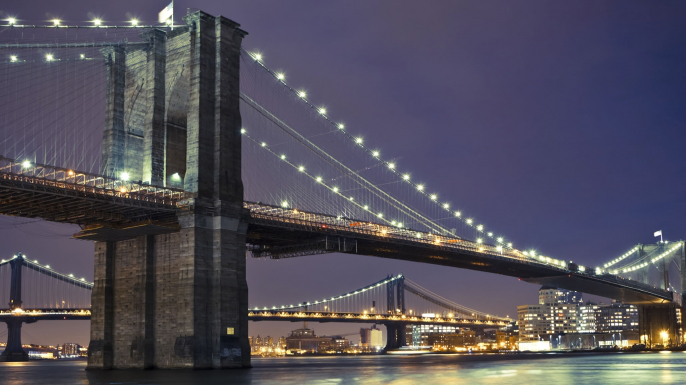

In [8]:
content_img = Image.open(PATH+IMG);content_img

In style transfer, we will be using a pre-trained VGG16 model to achieve our desired results.

In order to work with a pre-trained VGG model, we need to pre_process the image in the same way as the authors of VGG. Conveniently, Keras's VGG16 comes with a pre-process function that does it for us.

In [4]:
def preprocess_image(img):
    img = img_to_array(img)
    
    #convert (img_height, img_width, n_channels) to (1,img_height, img_width, n_channels)
    img = np.expand_dims(img, axis=0) # VGG expects images in batches, so we create a batch of 1 here
    img = preprocess_input(img)
    return img

In [11]:
content_img_arr = preprocess_image(img)

In [12]:
content_img_shape = content_img_arr.shape
content_img_shape

(1, 385, 686, 3)

Let us see how the pre-processed image looks like.

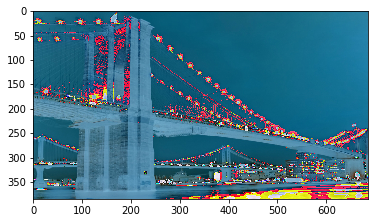

In [13]:
plt.imshow( content_img_arr[0])
plt.show()

For display purposes, when we are showing the final stylized image, we need to undo the pre-processing we had done to get back the original colors.

In [5]:
def depreprocess_image(x, shape):

    x = x.reshape(shape)
    x = x + [123.68, 116.779, 103.939] #add the mean of the ImageNet dataset.
    # 'BGR'->'RGB'
    x = x[:, :,:, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    

Let us try to get back the content image from the processed one.

(1, 385, 686, 3)


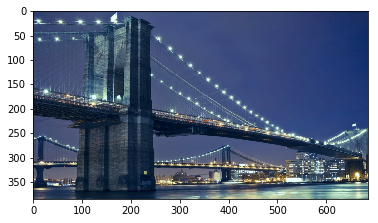

In [15]:
org = depreprocess_image(content_img_arr,shape)
print(org.shape)
plt.imshow(org[0])
plt.show()

In [19]:
gc.collect()

0

Let us now get a pre-trained VGG model

In [20]:
base_vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=content_img_shape[1:])
base_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 385, 686, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 385, 686, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 385, 686, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 192, 343, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 192, 343, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 192, 343, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 96, 171, 128)      0         
__________

## Single Content Output, Multiple Style Output

We now need to decide which layers of the VGG network to look at, i.e. the activations of which conv layers we should look at when we feed the content image into the network.

One particular aspect to keep note of is that the conv layers at the bottom ( or at the beginning of the model) capture the finer aspects of the image and have a lower receptive field. These layers try to find edges and other such similar things but they cannot capture the basic idea of the image. 

The conv layers at the top (or at the end) of the models have a larger receptive field, i.e. they capture the broader aspects of the image, such as here should be a beak of the bird and that is how it should look, this is how a human face might look like, etc.

As such, here we have selected a conv layer which is towards the end of the model.

**NOTE**

The base VGG architecture works with MaxPooling. When we do MaxPooling we actually lose some of finer information about the image, which is good for classification since we want the later conv layers to look at the broader aspects of the image, but in our case, it might lead to less fine images. 

We will later try style transfer with a VGG model which has AveragePooling instead of MaxPooling. But lets continue with this for now ...

### Visualizing Tranformation of Random Noise Image To Content Image

Before building the whole style transfer network, first let us try and visualize how we can transform the noise image into the activation outputs of conv layers for content image as well as the style image.

Looking at the content image now.

In [22]:
CONV_LAYER = 'block4_conv3'

Let us now get the output of this conv layer.

In [23]:
conv_layer_output = base_vgg_model.get_layer(CONV_LAYER).output

Now we want to snip our VGG model such that given an input image, we can get the outputs of this conv layer.

In [24]:
layer_model = Model(inputs=base_vgg_model.input, outputs=conv_layer_output)

Our target for the content loss is the activations of the network at the above conv layer when it is passed the content image.

In [25]:
content_target = K.variable(layer_model.predict(content_img_arr))

In [6]:
class Evaluator(object):
    def __init__(self, fn, shape):
        self.fn = fn
        self.shape = shape
        
    def get_loss(self, x):
        x = x.reshape(self.shape)
        output = self.fn([x])
        loss = output[0].astype('float64')
        self.grads = np.array(output[1:])
        return loss
    
    def get_grads(self, x):
        return self.grads.flatten().astype('float64')


In the next cell, we calculate the loss and the gradients of the loss w.r.t to the input. The scipy optimizer can work without giviing the gradient calculations. It will use finite differencing method which will be painfully slow. Since we already know how to calculate the gradients, why not use them and nudge the optimizer along the correct path :)

Next we define a Keras function which when given an input to the VGG model, gives us the loss and gradient as calculated above.

Next we define an Evaluator class object. We do this because we need to pass the loss function which we want to minimize and the gradient calculations to the optimizer.

Reference : https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html

In [28]:
gc.collect()

0

In [29]:
loss = K.mean(metrics.mse(conv_layer_output,content_target))
grads = K.gradients(loss, base_vgg_model.input)
fn = K.function([base_vgg_model.input], [loss]+grads)
eval_obj = Evaluator(fn,shape)

In [7]:
def solver(eval_obj, iters, x, shape, target = 'content'):
    
    for i in range(iters):
        print("Iteration : " + str(i))
        x, min_value, info = fmin_l_bfgs_b(eval_obj.get_loss, x.flatten(), \
                                           fprime=eval_obj.get_grads, maxfun=20)
        
        x = np.clip(x, -127,127)
        print(" Loss at iteration "+str(i) + " is : "+str(min_value))
        
        # Let us save how the random noise image looks life after each transformation
        BASE_STRING = 'res_at_iteration_'
        NAME = BASE_STRING + target + '_'
        fname = RESULTS+NAME+ str(i) +'.png' 
        imageio.imwrite(fname, depreprocess_image(x.copy(), shape)[0])
    return x

Let us now create a random noise image.

In [33]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)
x = rand_img(content_img_shape)
plt.imshow(x[0]);

NameError: name 'content_img_shape' is not defined

In [47]:
x.shape

(1, 385, 686, 3)

In [48]:
iterations = 15

In [49]:
x = solver(eval_obj, iterations, x, content_img_shape, 'content')

Iteration : 0
 Loss at iteration 0 is : 1449.02819824
Iteration : 1
 Loss at iteration 1 is : 612.388122559
Iteration : 2
 Loss at iteration 2 is : 381.801025391
Iteration : 3
 Loss at iteration 3 is : 276.577423096
Iteration : 4
 Loss at iteration 4 is : 217.924575806
Iteration : 5
 Loss at iteration 5 is : 181.549041748
Iteration : 6
 Loss at iteration 6 is : 157.898162842
Iteration : 7
 Loss at iteration 7 is : 140.932937622
Iteration : 8
 Loss at iteration 8 is : 127.874938965
Iteration : 9
 Loss at iteration 9 is : 116.807014465
Iteration : 10
 Loss at iteration 10 is : 108.001869202
Iteration : 11
 Loss at iteration 11 is : 101.279563904
Iteration : 12
 Loss at iteration 12 is : 94.6265029907
Iteration : 13
 Loss at iteration 13 is : 88.997795105
Iteration : 14
 Loss at iteration 14 is : 84.016708374


Let us now see how the random noise image looks like after the last iteration.

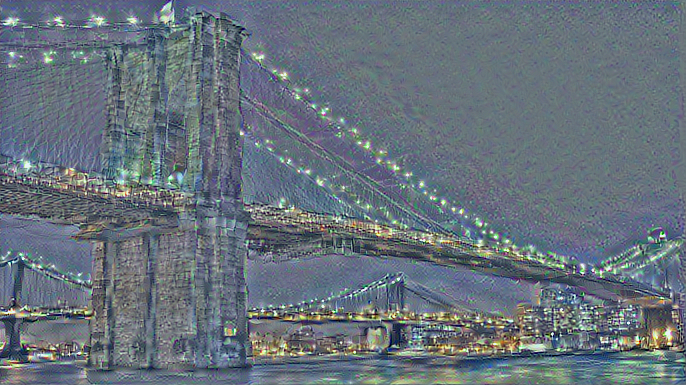

In [50]:
Image.open(RESULTS + 'res_at_iteration_content_14.png')

As we see, the random noise image was transformed by the optimizer to look a lot like the content image. We can look at a beautiful animation to see how the noise image was transformed.

In [40]:
from IPython.display import HTML
from matplotlib import animation,rc

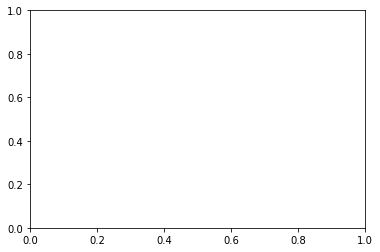

In [42]:
fig, ax = plt.subplots()


In [102]:
def animate_content(i):
    fname = RESULTS + 'res_at_iteration_content_'+str(i)+'.png'
    ax.imshow(Image.open(fname))

In [103]:
anim = animation.FuncAnimation(fig, animate_content, frames = 10, interval = 200)
HTML(anim.to_html5_video())

### Visualizing Tranformation of Random Noise Image To Style Image

Looking at the style image now.

Let us now look at Van Gogh's 'Starry Night'

In [107]:
style = Image.open(PATH+'starry-night.jpg')

We need the style and the content image to be of the same size and shape. So we resize our style image to be of similar scale to the content image.

In [108]:
style = style.resize((content_img_shape[2], content_img_shape[1]))

In [109]:
gc.collect()

6250

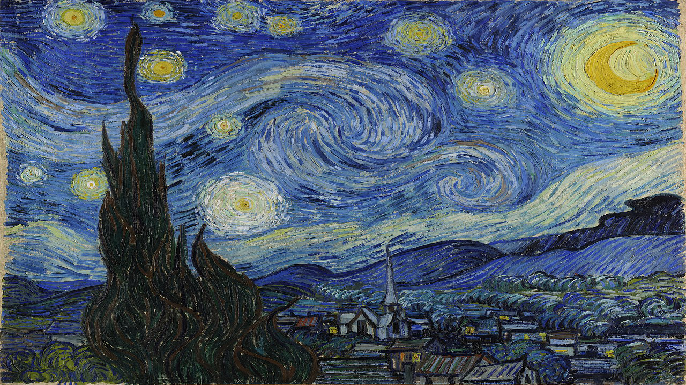

In [110]:
style

Now, we need to preprocess the style image

In [111]:
style_arr = preprocess_image(style)

In [112]:
style_shape = style_arr.shape
style_shape

(1, 385, 686, 3)

In [113]:
if content_img_shape == style_shape:
    print("So far so good!")
else : 
    print("Something wrong with the dimensions!!!")

So far so good!


Let's see how the preprocessed stlye painting/image looks like.

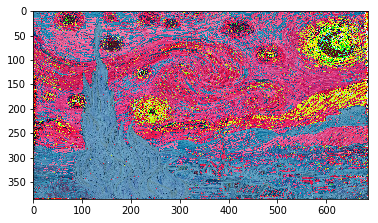

In [114]:
plt.imshow(style_arr[0]);plt.show()

Earlier, we said that we can work with multiple conv layer activations too. Though we selected only a single layer for our content image, we will be selecting multiple conv layer activations for our style image.

Create a dictionary mapping layer name to layer output. Will be used later to get output of multiple conv layers.

In [115]:
output_dict = {layer.name : layer.output for layer in base_vgg_model.layers}

In [116]:
output_dict

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(?, 385, 686, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(?, 385, 686, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, 192, 343, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 192, 343, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(?, 192, 343, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 96, 171, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 96, 171, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(?, 96, 171, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(?, 96, 171, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 48, 85, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(?, 48, 85, 512) dtype=float32>,
 'block

Let us now take the outputs of all the initial conv layers of all the convolutional blocks in our VGG network.

In [117]:
mul_conv_layer_outputs = []
for i in range(1,6):
    layer_name = 'block'+str(i)+'_conv1'
    output = output_dict[layer_name]
    mul_conv_layer_outputs.append(output)

In [118]:
mul_conv_layer_outputs

[<tf.Tensor 'block1_conv1/Relu:0' shape=(?, 385, 686, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 192, 343, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 96, 171, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu:0' shape=(?, 48, 85, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1/Relu:0' shape=(?, 24, 42, 512) dtype=float32>]

Creating a model which gives the output of the above multiple conv layers.

In [119]:
mul_layer_model = Model(base_vgg_model.input, mul_conv_layer_outputs)

In [120]:
style_targets = [K.variable(x) for x in mul_layer_model.predict(style_arr)]

The loss function for the style loss is a bit different. To recall, for content loss, we took the activations of the content image and the random noise image at some conv layer(s) and then found the MSE for them.

For style loss, what we do is we get the activations for the style image and the random noise image at some con layers. But instead of taking the MSE directly, we first calculate the normalized_gram_matrix for each. We then find the MSE between the gram matrices.


**Why do this for style loss?**

For the style image, we need to somehow capture the "style" across the painting. We do not care about the spatial aspect of the objects in the painting/image. In the gram matrix, we are doing a dot product of the feature with its transpose, i.e. we are multiplying every rows with every column. When we do this, we are somehow distributing the spatial information which was contained in the original style image.

Now that the image no longer has spatial information, what does it have? It has color, texture, i.e. *"style"*

This blog post does an excellent explanation of the need for gram matrices and of style transfer in general.

Reference : https://medium.com/artists-and-machine-intelligence/neural-artistic-style-transfer-a-comprehensive-look-f54d8649c199

In [8]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    gm = K.dot(features, K.transpose(features))
    gm_normalized = gm / (x.get_shape().num_elements()) # divide by the total elements in that tensor
    return gm_normalized

In [9]:
def style_loss(x,y):
    return metrics.mse(gram_matrix(x), gram_matrix(y))

Rest of the steps are similar to the content image steps.

In [123]:
loss = 0
for act_layer, tar_layer in zip(mul_conv_layer_outputs, style_targets):
    curr_loss = K.mean(style_loss(act_layer[0], tar_layer[0]))
    loss = curr_loss + loss

In [124]:
grads = K.gradients(loss, base_vgg_model.input)

In [125]:
style_fn = K.function([base_vgg_model.input], [loss]+grads)
style_eval_obj = Evaluator(style_fn, style_shape)

In [126]:
import scipy
#another_random_image = lambda shape : np.random.uniform(-2.5,2.5,style_shape)
x = rand_img(style_shape)

#In order to get the blurriness in the captured style 
#( we dont want fine edges in the style since that would domininate strongly )
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

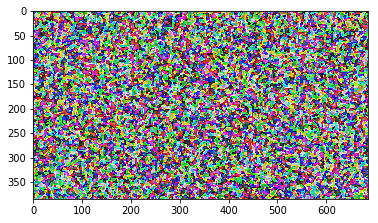

In [127]:
plt.imshow(x[0]);plt.show()

In [128]:
iterations = 15

In [129]:
x = solver(style_eval_obj, iterations, x, style_shape, 'style')

Iteration : 0
 Loss at iteration 0 is : 58277.2421875
Iteration : 1
 Loss at iteration 1 is : 3310.81298828
Iteration : 2
 Loss at iteration 2 is : 1328.48657227
Iteration : 3
 Loss at iteration 3 is : 730.18536377
Iteration : 4
 Loss at iteration 4 is : 505.226654053
Iteration : 5
 Loss at iteration 5 is : 384.948852539
Iteration : 6
 Loss at iteration 6 is : 321.437316895
Iteration : 7
 Loss at iteration 7 is : 267.953094482
Iteration : 8
 Loss at iteration 8 is : 232.369186401
Iteration : 9
 Loss at iteration 9 is : 206.623245239
Iteration : 10
 Loss at iteration 10 is : 188.01348877
Iteration : 11
 Loss at iteration 11 is : 172.933517456
Iteration : 12
 Loss at iteration 12 is : 159.694793701
Iteration : 13
 Loss at iteration 13 is : 149.656677246
Iteration : 14
 Loss at iteration 14 is : 139.719604492


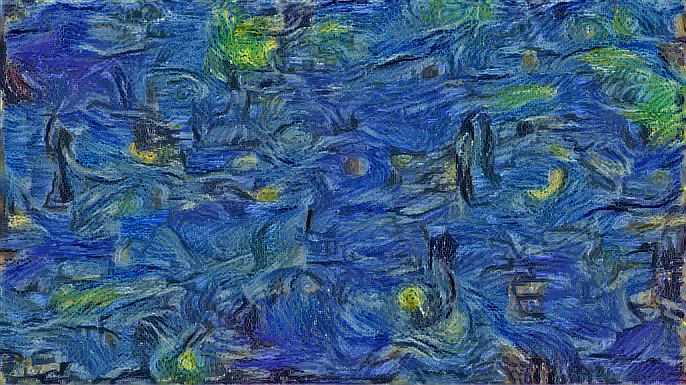

In [130]:
Image.open(RESULTS + 'res_at_iteration_style_14.png')

Its amazing how we can train a computer to capture the 'style' of an image!

In [131]:
def animate_style(i):
    fname = RESULTS + 'res_at_iteration_style_'+str(i)+'.png'
    ax.imshow(Image.open(fname))

In [132]:
anim = animation.FuncAnimation(fig, animate_style, frames = 10, interval = 200)
HTML(anim.to_html5_video())

## Bringing it all together

**Content Image**

[]

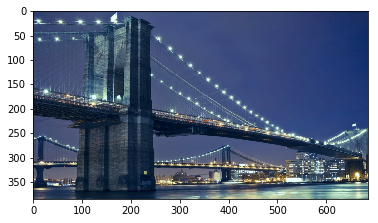

In [163]:
plt.imshow(depreprocess_image(content_img_arr, style_shape)[0]);plt.plot()

**Style Image**

[]

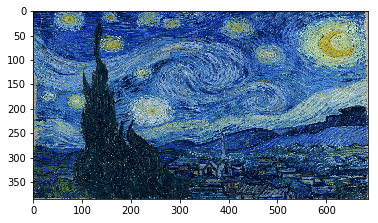

In [164]:
plt.imshow(depreprocess_image(style_arr, style_shape)[0]);plt.plot()

In [145]:
style_layers = []
for i in range(1,6):
    layer_name = 'block'+str(i)+'_conv1'
    output = output_dict[layer_name]
    style_layers.append(output)

In [146]:
style_layers

[<tf.Tensor 'block1_conv1/Relu:0' shape=(?, 385, 686, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 192, 343, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 96, 171, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu:0' shape=(?, 48, 85, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1/Relu:0' shape=(?, 24, 42, 512) dtype=float32>]

In [147]:
style_model = Model(inputs=base_vgg_model.input, outputs=style_layers)
style_targets = [K.variable(x) for x in style_model.predict(style_arr)]

In [148]:
content_layer = output_dict['block4_conv3']


In [149]:
content_layer

<tf.Tensor 'block4_conv3/Relu:0' shape=(?, 48, 85, 512) dtype=float32>

In [150]:
content_model = Model(inputs=base_vgg_model.input, outputs=content_layer)
content_targets = [K.variable(x) for x in content_model.predict(content_img_arr)]

In [151]:
content_loss = K.mean(metrics.mse(content_layer, content_targets))

Here we are also weighting the loss of each style layer individually. This is because we want the initial layers to hold less weight because they capture finer aspects and not the broader ones. 

In [179]:
style_losses = 0
style_wgts = [0.05,0.2,0.2,0.25,0.3]
for act_layer, tar_layer, w in zip(style_layers, style_targets, style_wgts):
    curr_loss = K.mean(style_loss(act_layer[0], tar_layer[0]))
    style_losses = curr_loss*w + style_losses

In [180]:
alpha = 4
beta = 1

Get the weighted sum of the content loss and the style loss as the total loss.

In [181]:
total_loss = alpha*content_loss + beta*style_losses

In [182]:
grads= K.gradients(total_loss, base_vgg_model.input)

In [183]:
total_loss_function = K.function([base_vgg_model.input], [total_loss] + grads)

In [184]:
total_eval_obj = Evaluator(total_loss_function,style_shape)

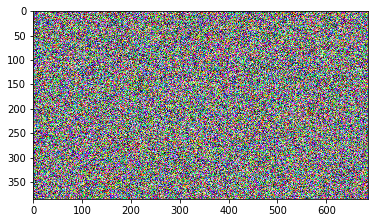

In [185]:
x = rand_img(style_shape)
plt.imshow(x[0]);plt.show()

In [188]:
iterations = 25

In [189]:
x = solver(total_eval_obj, iterations, x, style_shape, 'total')

Iteration : 0
 Loss at iteration 0 is : 58904.625
Iteration : 1
 Loss at iteration 1 is : 13236.5605469
Iteration : 2
 Loss at iteration 2 is : 7804.07421875
Iteration : 3
 Loss at iteration 3 is : 5903.78076172
Iteration : 4
 Loss at iteration 4 is : 4875.89746094
Iteration : 5
 Loss at iteration 5 is : 4285.38574219
Iteration : 6
 Loss at iteration 6 is : 3864.07177734
Iteration : 7
 Loss at iteration 7 is : 3564.10961914
Iteration : 8
 Loss at iteration 8 is : 3349.0234375
Iteration : 9
 Loss at iteration 9 is : 3199.9675293
Iteration : 10
 Loss at iteration 10 is : 3070.37353516
Iteration : 11
 Loss at iteration 11 is : 2960.69335938
Iteration : 12
 Loss at iteration 12 is : 2868.09448242
Iteration : 13
 Loss at iteration 13 is : 2792.6003418
Iteration : 14
 Loss at iteration 14 is : 2725.12158203
Iteration : 15
 Loss at iteration 15 is : 2665.66650391
Iteration : 16
 Loss at iteration 16 is : 2612.41455078
Iteration : 17
 Loss at iteration 17 is : 2567.97290039
Iteration : 18
 Los

Let us look at the result

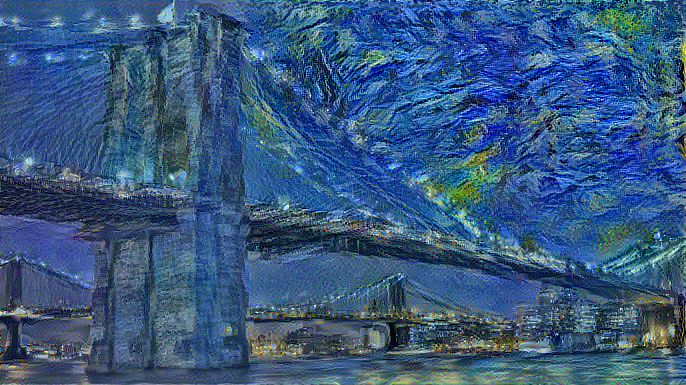

In [194]:
Image.open(RESULTS + 'res_at_iteration_total_24.png')

It is simply amazing how a random noise image was converted into a Brooklyn Bridge stylized in Van Gogh fashion!

In [191]:
def animate_total(i):
    fname = RESULTS + 'res_at_iteration_total_'+str(i)+'.png'
    ax.imshow(Image.open(fname))

In [193]:
anim = animation.FuncAnimation(fig, animate_total, frames = 20, interval = 200)
HTML(anim.to_html5_video())

## Multiple Content Output, Multiple Style Output

In the earlier example that we looked at, for the content image transformation, we only took a single conv layer output. Let us now try an example with multiple conv layer output for both content and style image.

In [10]:
IMG = 'my.jpeg'
new_content_image = Image.open(PATH+IMG)

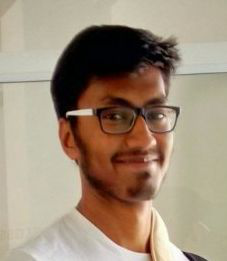

In [11]:
new_content_image

In [12]:
STYLE_NEW = 'wolf1.jpg'

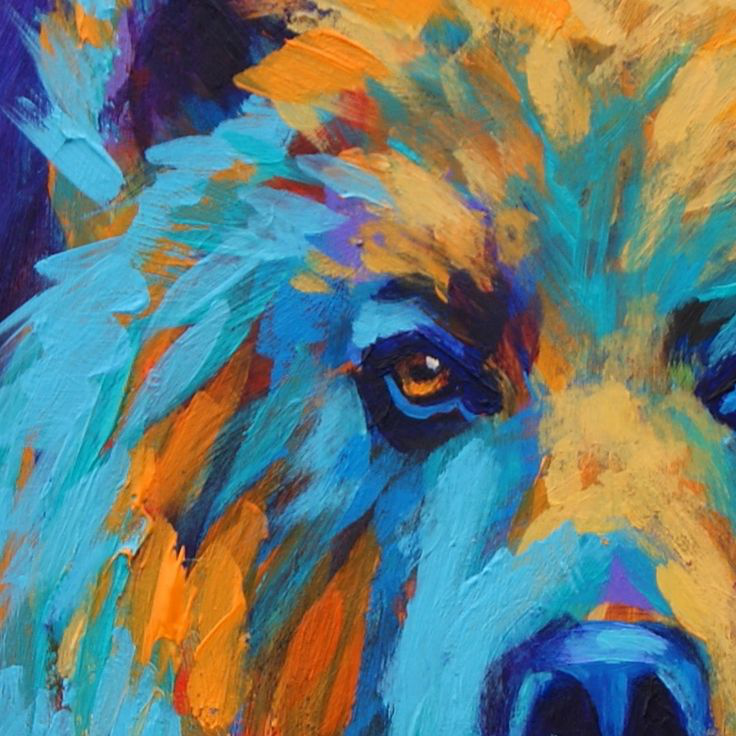

In [13]:
new_style_image = Image.open(PATH+STYLE_NEW);new_style_image

In [14]:
new_content_arr = preprocess_image(img=new_content_image)

In [15]:
new_content_shape = new_content_arr.shape
new_content_shape

(1, 261, 227, 3)

Let us now resize the style image to be the same as our content image.

In [16]:
new_style_image = new_style_image.resize((new_content_shape[2], new_content_shape[1]))

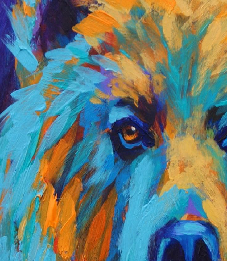

In [17]:
new_style_image

In [18]:
new_style_arr = preprocess_image(new_style_image)
new_style_shape = new_style_arr.shape
new_style_shape

(1, 261, 227, 3)

In [19]:
assert(new_style_shape == new_content_shape)

We need to get the VGG model again since the input shape has changed now.

In [20]:
base_vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=new_style_shape[1:])
base_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 261, 227, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 261, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 261, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 130, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 130, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 130, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 65, 56, 128)       0         
__________

In [21]:
output_dict = {layer.name : layer.output for layer in base_vgg_model.layers}

In [23]:
output_layers = []
for i in range(1,6):
    if i ==1 or i ==2:
         layer_name = 'block'+str(i)+'_conv2'
    else:
        layer_name = 'block'+str(i)+'_conv3'
    output = output_dict[layer_name]
    output_layers.append(output)

In [24]:
output_layers

[<tf.Tensor 'block1_conv2/Relu:0' shape=(?, 261, 227, 64) dtype=float32>,
 <tf.Tensor 'block2_conv2/Relu:0' shape=(?, 130, 113, 128) dtype=float32>,
 <tf.Tensor 'block3_conv3/Relu:0' shape=(?, 65, 56, 256) dtype=float32>,
 <tf.Tensor 'block4_conv3/Relu:0' shape=(?, 32, 28, 512) dtype=float32>,
 <tf.Tensor 'block5_conv3/Relu:0' shape=(?, 16, 14, 512) dtype=float32>]

In [25]:
full_model = Model(inputs=base_vgg_model.input, outputs=output_layers)

In [26]:
style_targets = [K.variable(x) for x in full_model.predict(new_style_arr)]
content_targets = [K.variable(x) for x in full_model.predict(new_content_arr)]

In [27]:
style_losses = 0
style_wgts = [0.05,0.2,0.2,0.25,0.3]
#style_wgts = [1,1,1,1,1]
for act_layer, tar_layer, w in zip(output_layers, style_targets, style_wgts):
    curr_loss = K.mean(style_loss(act_layer[0], tar_layer[0]))
    style_losses = curr_loss*w + style_losses

In [28]:
content_losses = 0
content_wgts = [0.05,0.05,0.2,0.3,0.4]
#content_wgts = [1,1,1,1,1]
for act_layer, tar_layer, w in zip(output_layers, content_targets, content_wgts):
    curr_loss = K.mean(metrics.mse(act_layer[0], tar_layer[0]))
    content_losses = curr_loss*w + content_losses

In [29]:
alpha = 0.1
beta = 1

In [30]:
gc.collect()

2940

In [31]:
total_loss = alpha*content_losses + beta*style_losses
grads= K.gradients(total_loss, base_vgg_model.input)
total_loss_function = K.function([base_vgg_model.input], [total_loss] + grads)
mul_total_eval_obj = Evaluator(total_loss_function, new_style_shape)

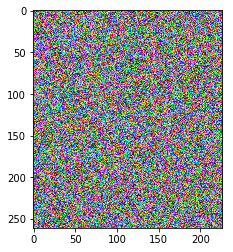

In [34]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)
x = rand_img(new_style_shape)
plt.imshow(x[0]);plt.show()

In [35]:
iterations = 15

In [36]:
x = solver(mul_total_eval_obj, iterations, x, new_style_shape, 'mul_total_wolf')

Iteration : 0
 Loss at iteration 0 is : 56432.15625
Iteration : 1
 Loss at iteration 1 is : 18233.5195312
Iteration : 2
 Loss at iteration 2 is : 13151.34375
Iteration : 3
 Loss at iteration 3 is : 10897.8164062
Iteration : 4
 Loss at iteration 4 is : 9597.88378906
Iteration : 5
 Loss at iteration 5 is : 8780.16601562
Iteration : 6
 Loss at iteration 6 is : 8199.29199219
Iteration : 7
 Loss at iteration 7 is : 7846.27050781
Iteration : 8
 Loss at iteration 8 is : 7507.16259766
Iteration : 9
 Loss at iteration 9 is : 7281.39746094
Iteration : 10
 Loss at iteration 10 is : 7120.296875
Iteration : 11
 Loss at iteration 11 is : 6953.70605469
Iteration : 12
 Loss at iteration 12 is : 6802.17578125
Iteration : 13
 Loss at iteration 13 is : 6705.04199219
Iteration : 14
 Loss at iteration 14 is : 6614.36376953


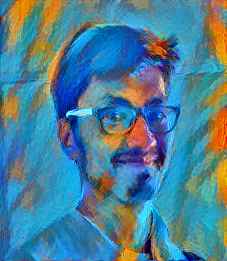

In [37]:
Image.open(RESULTS + 'res_at_iteration_mul_total_wolf_14.png')

In [38]:
def animate_mul_total(i):
    fname = RESULTS + 'res_at_iteration_mul_total_wolf_'+str(i)+'.png'
    ax.imshow(Image.open(fname))

In [43]:
anim = animation.FuncAnimation(fig, animate_mul_total, frames = 10, interval = 200)
HTML(anim.to_html5_video())

What if we start with the initial content or style image itself instead of random noise? Let's explore!

Starting with the content image.

In [44]:
x = solver(mul_total_eval_obj, iterations, new_content_arr, new_style_shape, 'mul_total_wolf_st_c')

Iteration : 0
 Loss at iteration 0 is : 23851.6445312
Iteration : 1
 Loss at iteration 1 is : 10772.1523438
Iteration : 2
 Loss at iteration 2 is : 8582.30175781
Iteration : 3
 Loss at iteration 3 is : 7552.5703125
Iteration : 4
 Loss at iteration 4 is : 6956.21630859
Iteration : 5
 Loss at iteration 5 is : 6657.75488281
Iteration : 6
 Loss at iteration 6 is : 6442.67675781
Iteration : 7
 Loss at iteration 7 is : 6327.87353516
Iteration : 8
 Loss at iteration 8 is : 6201.77441406
Iteration : 9
 Loss at iteration 9 is : 6114.76269531
Iteration : 10
 Loss at iteration 10 is : 6040.2421875
Iteration : 11
 Loss at iteration 11 is : 5989.74707031
Iteration : 12
 Loss at iteration 12 is : 5948.05957031
Iteration : 13
 Loss at iteration 13 is : 5909.51367188
Iteration : 14
 Loss at iteration 14 is : 5878.67822266


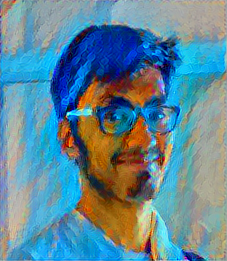

In [45]:
Image.open(RESULTS + 'res_at_iteration_mul_total_wolf_st_c_14.png')

In [46]:
def animate_mul_total_st_c(i):
    fname = RESULTS + 'res_at_iteration_mul_total_wolf_st_c_'+str(i)+'.png'
    ax.imshow(Image.open(fname))

anim = animation.FuncAnimation(fig, animate_mul_total_st_c, frames = 10, interval = 200)
HTML(anim.to_html5_video())

Starting with the style image.

In [47]:
x = solver(mul_total_eval_obj, iterations, new_style_arr, new_style_shape, 'mul_total_wolf_st_s')

Iteration : 0
 Loss at iteration 0 is : 9496.47753906
Iteration : 1
 Loss at iteration 1 is : 8633.12402344
Iteration : 2
 Loss at iteration 2 is : 8150.45703125
Iteration : 3
 Loss at iteration 3 is : 7814.953125
Iteration : 4
 Loss at iteration 4 is : 7553.60498047
Iteration : 5
 Loss at iteration 5 is : 7397.41210938
Iteration : 6
 Loss at iteration 6 is : 7262.40673828
Iteration : 7
 Loss at iteration 7 is : 7159.74462891
Iteration : 8
 Loss at iteration 8 is : 7054.61816406
Iteration : 9
 Loss at iteration 9 is : 6988.96875
Iteration : 10
 Loss at iteration 10 is : 6903.30224609
Iteration : 11
 Loss at iteration 11 is : 6851.76269531
Iteration : 12
 Loss at iteration 12 is : 6798.16943359
Iteration : 13
 Loss at iteration 13 is : 6756.10595703
Iteration : 14
 Loss at iteration 14 is : 6707.31787109


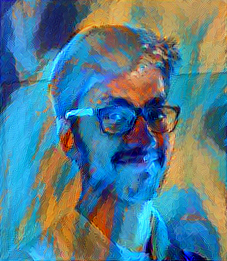

In [48]:
Image.open(RESULTS + 'res_at_iteration_mul_total_wolf_st_s_14.png')

In [49]:
def animate_mul_total_st_s(i):
    fname = RESULTS + 'res_at_iteration_mul_total_wolf_st_s_'+str(i)+'.png'
    ax.imshow(Image.open(fname))

anim = animation.FuncAnimation(fig, animate_mul_total_st_s, frames = 10, interval = 200)
HTML(anim.to_html5_video())